In [1]:
from tomoSegmentPipeline.showcaseResults import (predict_fullTomogram, load_model, load_tomoData, Tversky_index,
                                        fullTomogram_modelComparison, make_comparison_plot, write_comparison_gif, save_classPred)

from tomoSegmentPipeline.losses import Tversky_loss
from tomoSegmentPipeline.utils.common import read_array
import tomoSegmentPipeline.dataloader as dl
from tomoSegmentPipeline.utils import setup
from tomoSegmentPipeline.dataloader import to_categorical, transpose_to_channels_first
from tomoSegmentPipeline.trainWrapper import make_trainer

PARENT_PATH = setup.PARENT_PATH
CRYOCARE_TOMO_PATH = setup.CRYOCARE_TOMO_PATH
RAW_TOMO_PATH = setup.RAW_TOMO_PATH
CRYOCARE_ISONET_TOMO_PATH = setup.CRYOCARE_ISONET_TOMO_PATH

ISONET_PATH = '/home/haicu/jeronimo.carvajal/Thesis/data/isoNet/'

import numpy as np
import matplotlib.pyplot as plt
import random
import mrcfile
import pandas as pd
import torch
import os
from glob import glob

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

# Input tomogram normalization

In [3]:
# --snrfalloff 1 --deconvstrength 1

raw_tomo_path = os.path.join(ISONET_PATH, 'RAW_dataset/RAW_tomoset/')

isonet_training_tomos = ['tomo10.mrc', 'tomo04.mrc', 'tomo32.mrc', 'tomo38.mrc']

for tomo in sorted(isonet_training_tomos):
    print('reading raw...')
    raw_data = read_array(os.path.join(raw_tomo_path, tomo))

reading raw...
reading raw...
reading raw...
reading raw...


(array([1.70000000e+01, 8.60000000e+01, 1.41800000e+03, 1.15890600e+06,
        7.17570840e+07, 2.63302078e+08, 6.24971430e+07, 8.71749000e+05,
        8.88000000e+02, 7.00000000e+00]),
 array([-10.362247  ,  -8.469565  ,  -6.576884  ,  -4.684202  ,
         -2.7915204 ,  -0.8988385 ,   0.99384326,   2.8865252 ,
          4.7792068 ,   6.671889  ,   8.56457   ], dtype=float32),
 <BarContainer object of 10 artists>)

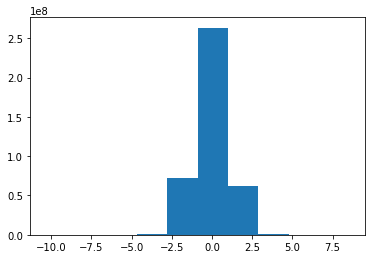

In [4]:
plt.hist(raw_data.flatten())

(array([ 7681455., 16014110., 35240607., 60315772., 80483942., 80512463.,
        60357178., 35276284., 16026912.,  7680653.]),
 array([-2.6026301e+00, -2.0821595e+00, -1.5616888e+00, -1.0412182e+00,
        -5.2074748e-01, -2.7680397e-04,  5.2019387e-01,  1.0406646e+00,
         1.5611352e+00,  2.0816059e+00,  2.6020765e+00], dtype=float32),
 <BarContainer object of 10 artists>)

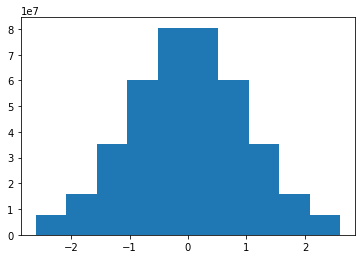

In [5]:
aux = np.clip(raw_data, np.quantile(raw_data, 0.005), np.quantile(raw_data, 0.995))
plt.hist(aux.flatten())

In [6]:
raw_data.mean(), raw_data.std()

(-3.3087296e-08, 0.9999998)

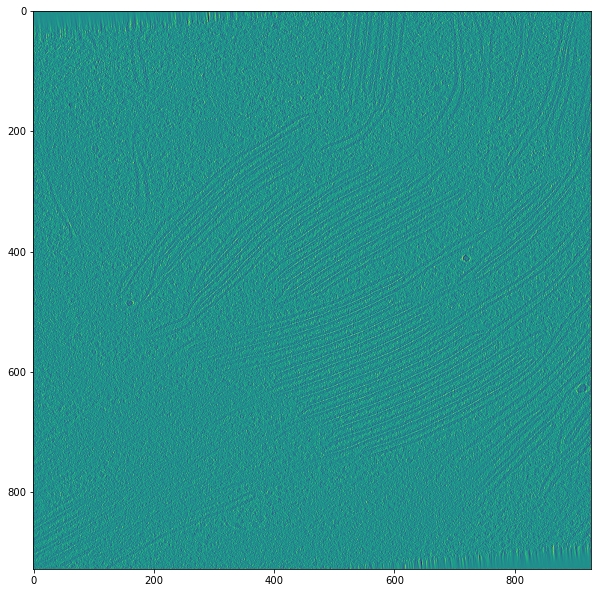

In [9]:
plt.figure(figsize=(10, 12))
plt.imshow(aux[230])

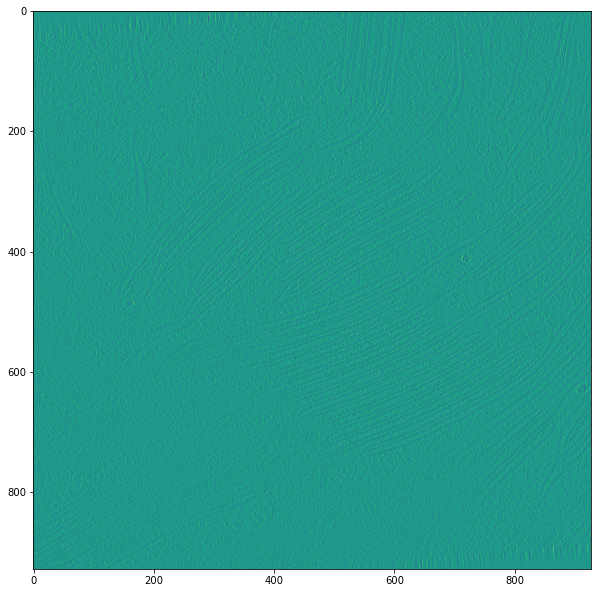

In [ ]:
plt.figure(figsize=(10, 12))
plt.imshow(raw_data[230])

In [ ]:
for tomo in sorted(training_tomos):
    print('reading raw...')
    full_path = os.path.join(raw_tomo_path, tomo)
    raw_data = read_array(full_path)
    raw_data = (raw_data-raw_data.mean())/raw_data.std()
    raw_data = raw_data.astype(np.float32)
    write_array(raw_data, full_path)
    
raw_data = read_array(full_path)
raw_data.mean(), raw_data.std()

# Review IsoNet outputs

## Full tomograms

reading raw...
reading deconv...
reading mask...
reading corrected...


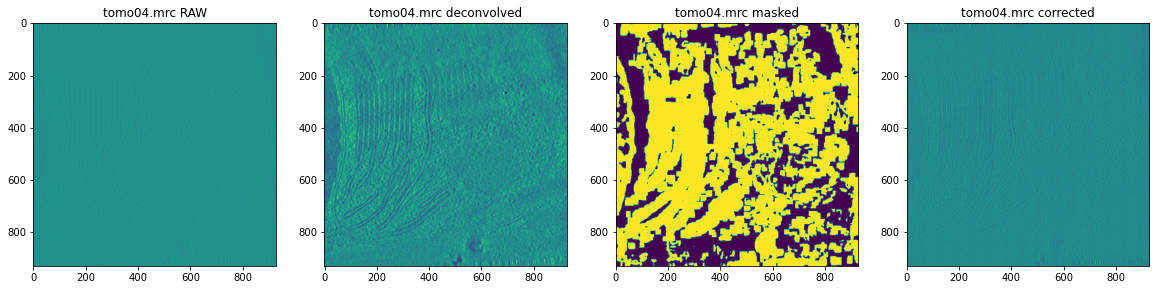

reading raw...
reading deconv...
reading mask...
reading corrected...


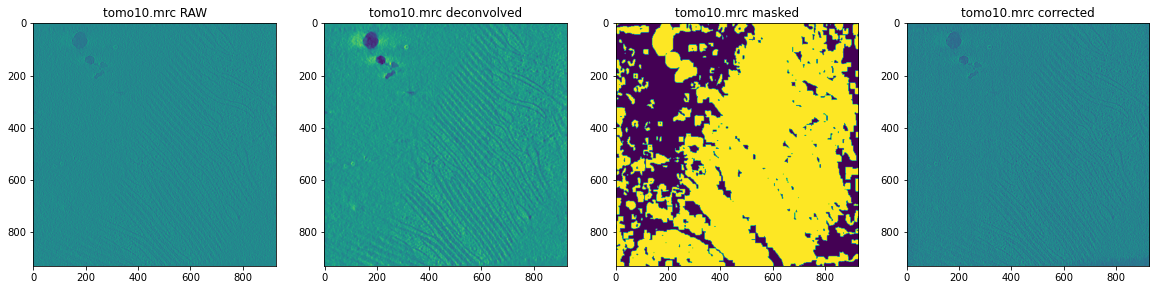

reading raw...
reading deconv...
reading mask...
reading corrected...


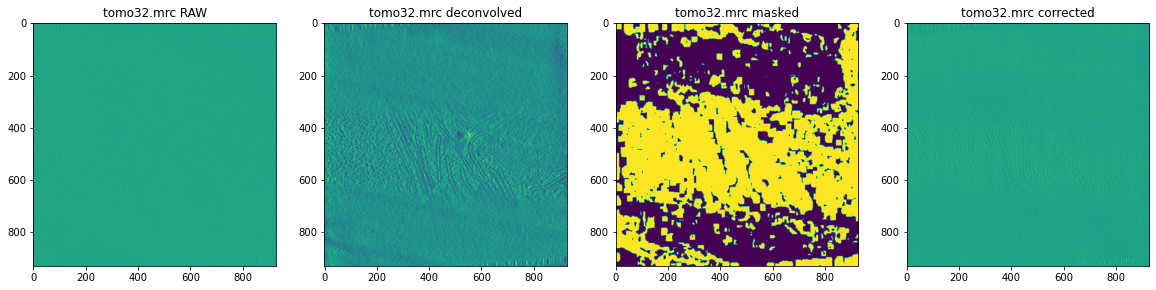

reading raw...
reading deconv...
reading mask...
reading corrected...


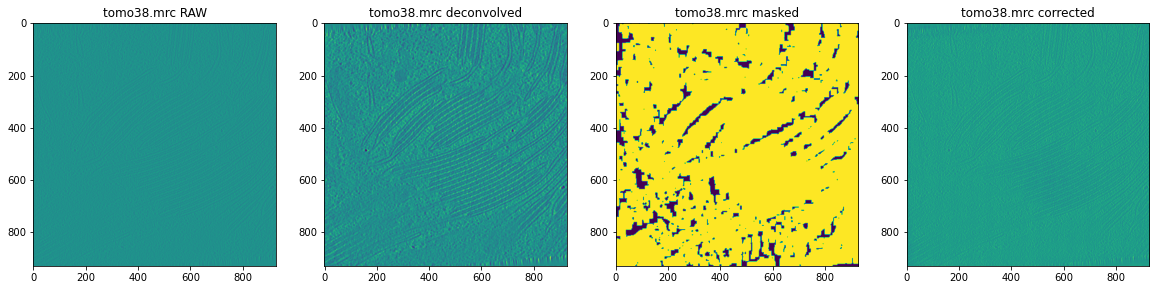

In [15]:
# --snrfalloff 1 --deconvstrength 1

raw_tomo_path = os.path.join(ISONET_PATH, 'RAW_tomoset/')
deconv_tomo_path = os.path.join(ISONET_PATH, 'RAW_tomos_deconv/')
mask_tomo_path = os.path.join(ISONET_PATH, 'RAW_tomos_mask/')
corrected_tomo_path = os.path.join(ISONET_PATH, 'RAW_corrected_i30/')

isonet_training_tomos = ['tomo10.mrc', 'tomo04.mrc', 'tomo32.mrc', 'tomo38.mrc']

for tomo in sorted(isonet_training_tomos):
    print('reading raw...')
    raw_data = read_array(os.path.join(raw_tomo_path, tomo))
    
    print('reading deconv...')
    deconv_data = read_array(os.path.join(deconv_tomo_path, tomo))
    
    print('reading mask...')
    masked_data = read_array(os.path.join(mask_tomo_path, tomo[0:6]+'_mask.mrc'))
    
    print('reading corrected...')
    corrected_data = read_array(os.path.join(corrected_tomo_path, tomo[0:6]+'_corrected.mrc'))
    
    fig, ax = plt.subplots(1, 4, figsize=(20, 15))
        
    z_idx = raw_data.shape[0]//2
    ax[0].imshow(raw_data[z_idx])
    ax[0].set_title(tomo + ' RAW')
    ax[1].imshow(deconv_data[z_idx])
    ax[1].set_title(tomo + ' deconvolved')
    ax[2].imshow(masked_data[z_idx])
    ax[2].set_title(tomo + ' masked')
    ax[3].imshow(corrected_data[z_idx])
    ax[3].set_title(tomo + ' corrected')
    
    plt.show()

Text(0.5, 1.0, 'tomo38.mrc corrected')

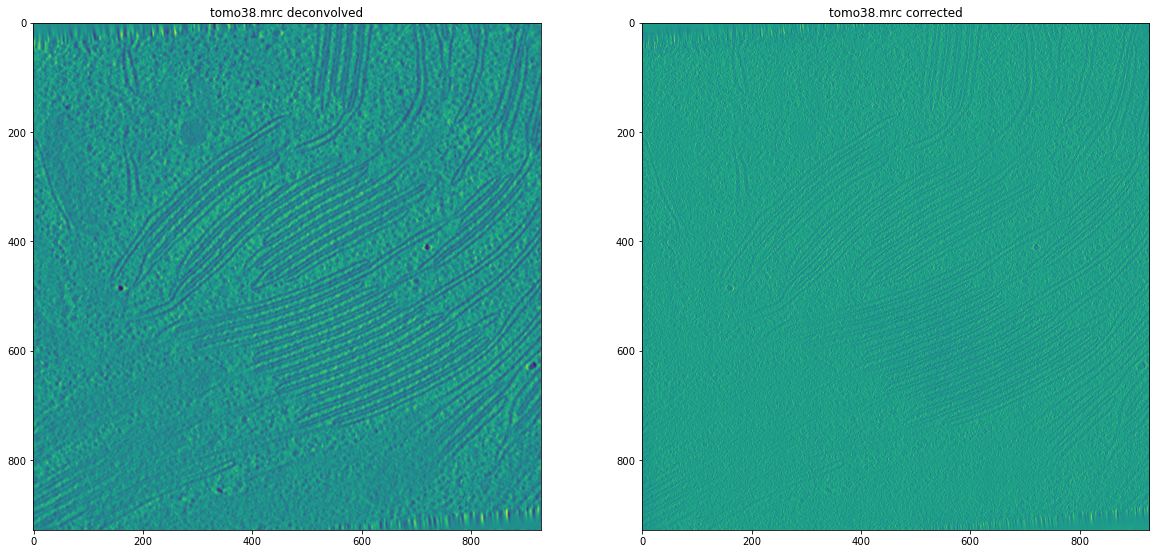

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20, 15))
        
z_idx = raw_data.shape[0]//2
ax[0].imshow(deconv_data[z_idx])
ax[0].set_title(tomo + ' deconvolved')
ax[1].imshow(corrected_data[z_idx])
ax[1].set_title(tomo + ' corrected')

## Checking that Missing wedge in Fourier space corresponds to the XZ plane

In [ ]:
ISONET_PATH = '/home/haicu/jeronimo.carvajal/Thesis/data/isoNet/'

raw_tomo_path = os.path.join(ISONET_PATH, 'RAW_tomoset/')

isonet_training_tomos = ['tomo10.mrc', 'tomo04.mrc', 'tomo32.mrc', 'tomo38.mrc']

for tomo in sorted(isonet_training_tomos):
    print('reading raw...')
    raw_data = read_array(os.path.join(raw_tomo_path, tomo))
    break
    
tomo_shape = raw_data.shape
subtomo_fft = np.fft.fftn(raw_data)

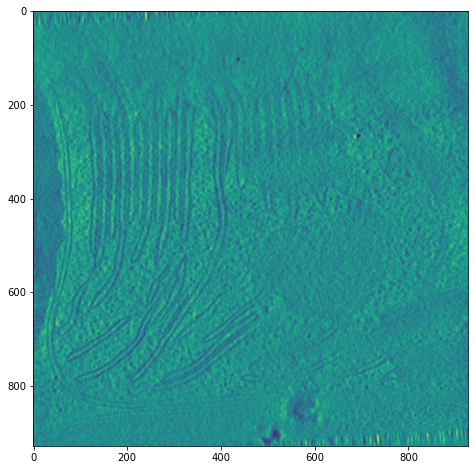

In [4]:
plt.figure(figsize=(12, 8))
plt.imshow(raw_data[tomo_shape[0]//2])

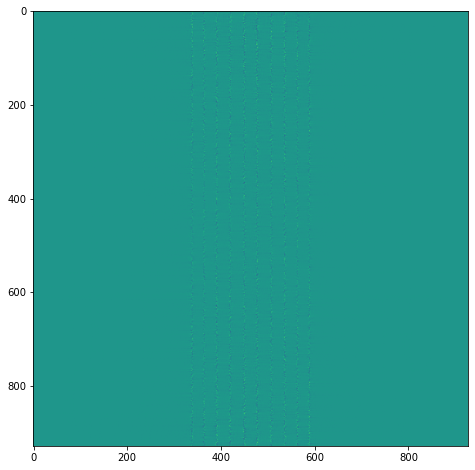

In [5]:
plt.figure(figsize=(12, 8))
plt.imshow(np.real(subtomo_fft)[tomo_shape[0]//2])

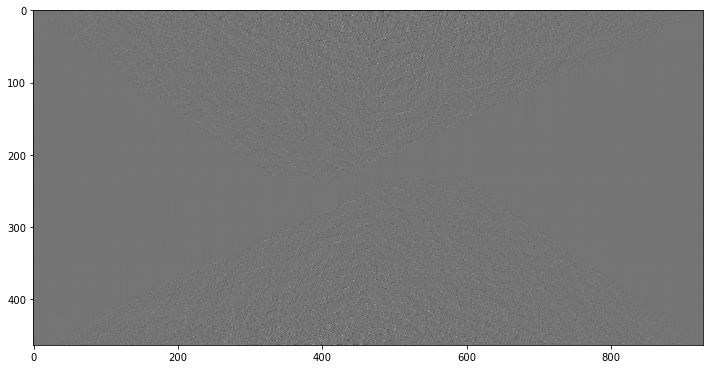

In [10]:
plt.figure(figsize=(12, 8))
plt.imshow(np.real(subtomo_fft)[:, tomo_shape[1]//2, :]) # Z, Y, X

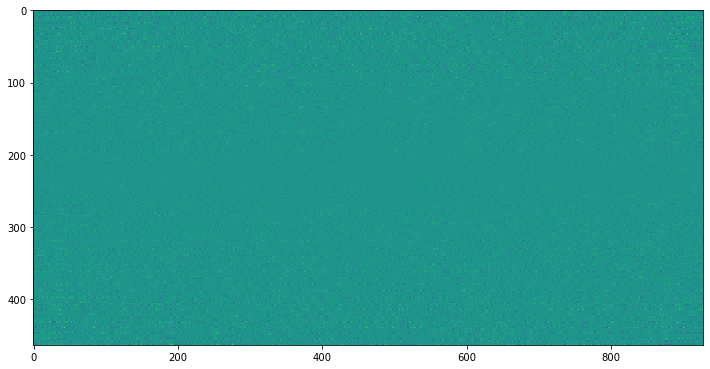

In [7]:
plt.figure(figsize=(12, 8))
plt.imshow(np.real(subtomo_fft)[:, :, tomo_shape[2]//2])

## Different model iterations on given training patches

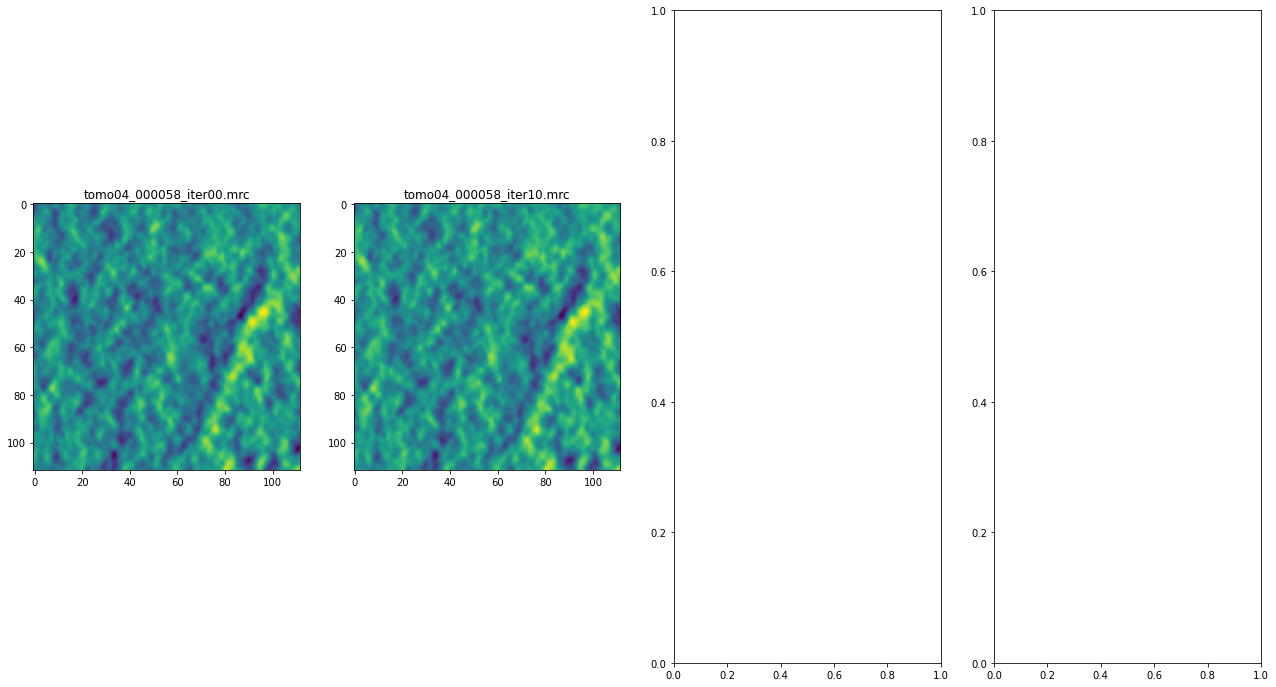

In [12]:
n_iter = 30

tomo_name = 'tomo04'

# results_path = os.path.join(ISONET_PATH, 'cryoCARE_results/')
# results_path = os.path.join(ISONET_PATH, 'RAW_dataset/RAW_results/')
results_path = os.path.join(ISONET_PATH, 'RAW_dataset/refine_pilot/run0/RAW_results/')
tomo_iterations = glob(results_path+tomo_name+'*_000058_*')

tomo_iterations = sorted(tomo_iterations)

counter = 0
nrows = n_iter//10 + 1 
fig, ax = plt.subplots(1, nrows, figsize=(22, 12))

for iter_patch in tomo_iterations:
    data = read_array(iter_patch)
   
    title = iter_patch.split('/')[-1]
    
    z_idx = data.shape[0]//2
    
    if counter%10==0:
        ax[counter//10].imshow(data[z_idx])
        ax[counter//10].set_title(title)
        
    counter+=1

# Patches from different tomosets show corresponding areas

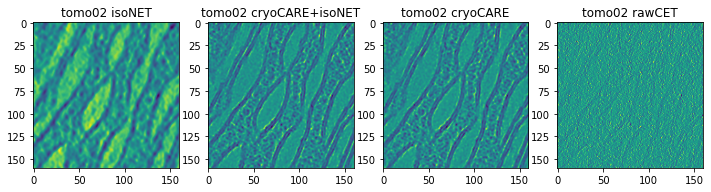

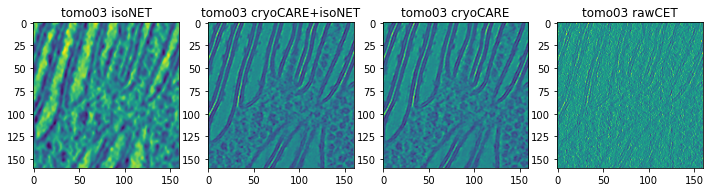

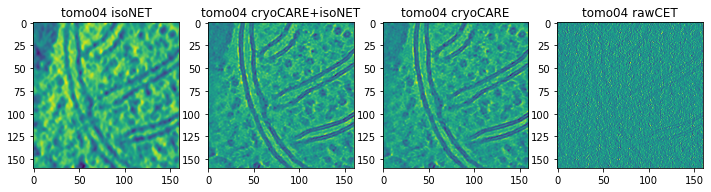

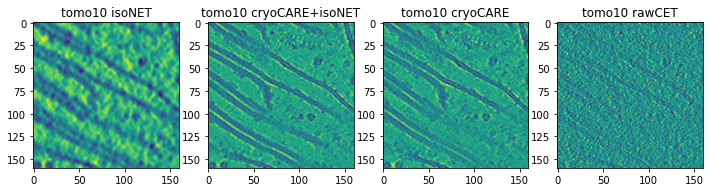

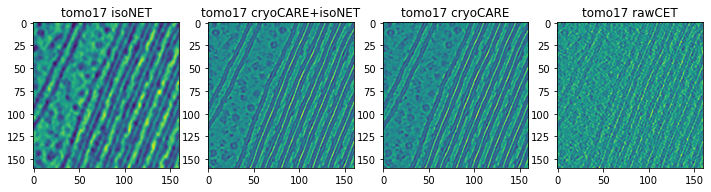

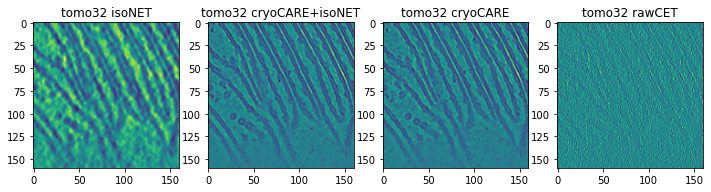

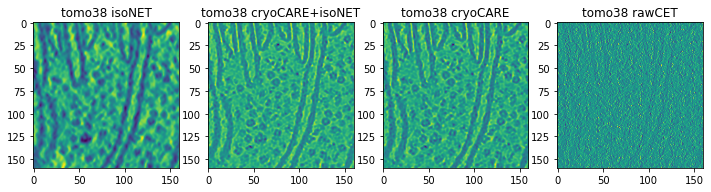

In [13]:
for tomo_idx in ['02', '03', '04', '10', '17', '32', '38']:
    
    input_types = ['isoNET', 'cryoCARE+isoNET', 'cryoCARE', 'rawCET']
    fig, ax = plt.subplots(1, len(input_types), figsize=(12, 8))
    
    
    for i in range(len(input_types)):
        
        paths_image, _ = setup.get_paths(['tomo'+tomo_idx], input_types[i])
        
        data_aray = read_array(paths_image[5])
        
        z_idx = 80
        ax[i].imshow(data_aray[z_idx])
        ax[i].set_title('tomo'+tomo_idx + ' ' + input_types[i])
        
    plt.show()

In [8]:
raw_fullTomo_path = PARENT_PATH+'data/raw_cryo-ET/tomo17.mrc'
cryoCARE_fullTomo_path = PARENT_PATH+'data/nnUnet/nifti_files/tomo17_bin4_denoised_0000.nii.gz'

with mrcfile.open(raw_fullTomo_path, permissive=True) as mrc:
    print(mrc)

MrcFile('/home/haicu/jeronimo.carvajal/Thesis/data/raw_cryo-ET/tomo17.mrc', mode='r')


In [11]:
mrc.extended_header